In [1]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib import pyplot as plt
import pandas as pd

# Data Exploration, Visualization and Quality Assessment

As mention in the project intro, in the real project we have 2M samples but this data cannot be shared, I've extracted a 30M sample dataset that I used during the training process. 

The data exploration starts sampling the 2M dataset trying to keep the crop code distrutions, so the sample faithfully represents the original data. 

As you can see in the notebook, some of the crop categories has extreamly high apparition frequencies, to avoid problemas with the model, we oversample the less represented categories to keep a mininum sample size of 1000.
One crop category has been discarted because there's no enough data in the samples.


In [2]:
data_file = "/media/data/projects/crophisto/data.npy"
data = np.load(data_file)
y = data[:, 11]
X = data[:, :11]

In [3]:
print("Number of samples in the dataste: {}".format(y.shape[0]))

Number of samples in the dataste: 1984471


In [4]:
# use StratifiedShuffleSplit from sklearn to keep data distributions

sample_size = 15000
sss = StratifiedShuffleSplit(n_splits=1, test_size=sample_size, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
print(X_test.shape)
print(y_test.shape)    

(15000, 11)
(15000,)


So now we have 15K dataset, lets see if the crop distributions are the same.

Text(0.5, 1.0, 'sampled')

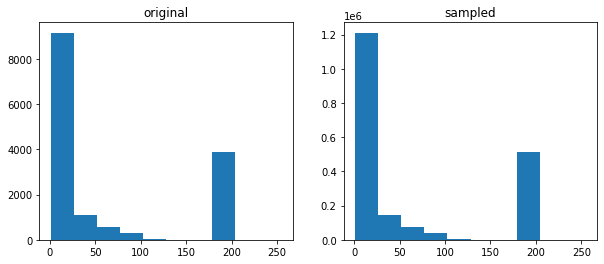

In [5]:
# find categories under represented
categories = np.sort(np.unique(y_test))

freq1, bins1 = np.histogram(y, bins=categories)
freq2, bins2 = np.histogram(y_test, bins=categories)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(y_test,)
axs[0].set_title("original")
axs[1].hist(y,)
axs[1].set_title("sampled")



As we can see, the categories are clearly unbalanced. This may suppose that the classifier tends to learn more accurately the patterns that the majority crops have as output, but those of less frequency won't are not adequately represented in the classifier hypothesis.
Although statistically this would make the classifier work "well", because in general terms it will give a good result if it hits the most representative classes, we are interested in that it is also capable of predicting other types of crops.

There are different techniques to deal with unbalanced groups (undersampling, oversampling, smote,) a library that implements this type of techniques and is of great help is [imbalanced-learn](https://imbalanced-learn.readthedocs.io/en/stable/index.html).

In this case, I have manually included a minimum of data for each category of crop. For each category, lest define the min number of samples as the 30% of the mean expected frequency, and calculate how many samples we have to add to each category.

Mean support: 556, mean_frequency: 3.70%
Min support: 1000, min_frequency: 1.11%


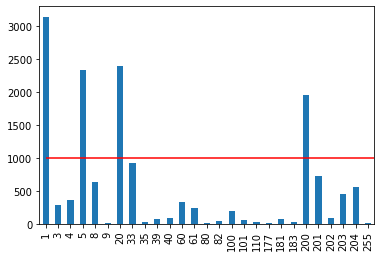

In [6]:
# find categories with less that min_size
num_categories = len(np.unique(y_test))
mean_frequency = (100/num_categories)/100 # porc
mean_support = round(sample_size * mean_frequency)
# min_frequency = mean_frequency * 0.15
min_frequency = mean_frequency * 0.30
min_support = 1000 #round(sample_size * min_frequency)
round(min_support)
print("Mean support: {}, mean_frequency: {:.2%}".format(mean_support, mean_frequency))
print("Min support: {}, min_frequency: {:.2%}".format(min_support, min_frequency))

# get frequency per category
categories = np.sort(np.unique(y_test))
freq_df = pd.DataFrame(y_test)
freq_df.columns = ["code"]
freq = freq_df["code"].value_counts().sort_index().values

fig = freq_df["code"].value_counts().sort_index().plot(kind='bar')
fig.hlines(min_support,0,max(y_test), colors="r")


In [7]:
freq

array([3143,  284,  356, 2335,  634,    9, 2393,  920,   27,   64,   83,
        324,  241,    5,   37,  192,   52,   24,    4,   65,   20, 1955,
        726,   86,  457,  561,    3])

In [8]:
print("Number of samples per category.")
print(categories)
print(freq)
print("Undersampled categories that need additional data.")

needed = (freq-min_support)
needed
needed[needed >0] = 0
needed = -1*needed
print(categories)

print("needed: \n{}".format(needed))


Number of samples per category.
[  1   3   4   5   8   9  20  33  35  39  40  60  61  80  82 100 101 110
 177 181 183 200 201 202 203 204 255]
[3143  284  356 2335  634    9 2393  920   27   64   83  324  241    5
   37  192   52   24    4   65   20 1955  726   86  457  561    3]
Undersampled categories that need additional data.
[  1   3   4   5   8   9  20  33  35  39  40  60  61  80  82 100 101 110
 177 181 183 200 201 202 203 204 255]
needed: 
[  0 716 644   0 366 991   0  80 973 936 917 676 759 995 963 808 948 976
 996 935 980   0 274 914 543 439 997]


Now lets iterate through each category addind the needed data.

In [9]:
needed = (freq-min_support)
needed
needed[needed >0] = 0
needed = -1*needed
print("Initial dataset shape: {} ".format(X.shape))
y_over = y_test.copy()
X_over = X_test.copy()

data_copy = data[:, 3:11]

for index, needed_for_category in enumerate(needed):
    if needed_for_category == 0:
        continue
    category_code = categories[index]
    
    print("Adding {} samples for category {}".format(needed_for_category, category_code))
    # filter data for this category
    cat_mask = (y_train == category_code)
    
    # define the lower bound as the limit of samples to get from this category
    bound = min(needed_for_category, len(cat_mask == True))
    cat_y = y_train[cat_mask][:bound]
    y_over = np.hstack([y_over,cat_y])

    cat_X = X_train[cat_mask,:][:bound,:]
    X_over = np.vstack([X_over,cat_X])


dataset = np.hstack([X_over, y_over.reshape(-1,1)])
print("Final dataset shape: {}".format(dataset.shape))

Initial dataset shape: (1984471, 11) 
Adding 716 samples for category 3
Adding 644 samples for category 4
Adding 366 samples for category 8
Adding 991 samples for category 9
Adding 80 samples for category 33
Adding 973 samples for category 35
Adding 936 samples for category 39
Adding 917 samples for category 40
Adding 676 samples for category 60
Adding 759 samples for category 61
Adding 995 samples for category 80
Adding 963 samples for category 82
Adding 808 samples for category 100
Adding 948 samples for category 101
Adding 976 samples for category 110
Adding 996 samples for category 177
Adding 935 samples for category 181
Adding 980 samples for category 183
Adding 274 samples for category 201
Adding 914 samples for category 202
Adding 543 samples for category 203
Adding 439 samples for category 204
Adding 997 samples for category 255
Final dataset shape: (31373, 12)


Lets take a look at the final sample vs original distribution

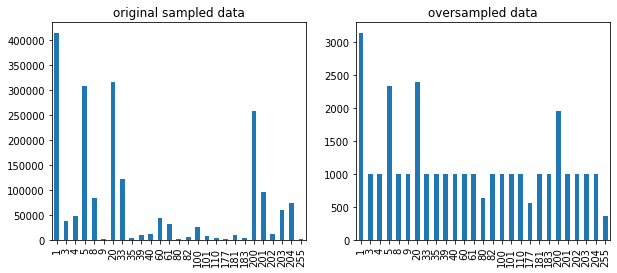

In [11]:
# get frequency per category
categories = np.sort(np.unique(y_test))
freq_df = pd.DataFrame(y_test)
freq_df.columns = ["code"]

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].set_title("original sampled data")
axs[1].set_title("oversampled data")
pd.value_counts(y).sort_index().plot(ax=axs[0],kind='bar')
pd.value_counts(y_over).sort_index().plot(ax=axs[1],kind='bar')


As we can see, for some categories we don't haven enough data to get a mininum sample size, we are going to turn out samples that has category 255 in any year or in the y column.

In [12]:
code = 255
dataset = dataset[~ (dataset[:]==code).any(1)]


In [13]:
#save the data

np.save("../resources/data_sampled", dataset)

## Data visualization
Some metrics that can give us some insight over the data:

In [15]:
y = data[:, 11]
X = data[:, :11]
last_year = X[:,-1]


In [17]:
print("Percentage of crops that have varied in the last year of the serie from the previous year: {} %".format(round(100*np.count_nonzero(last_year-y)/np.count_nonzero(y),2)))


Percentage of crops that have varied in the last year of the serie from the previous year: 62.66 %
